
# Python interface for thin shells
```
This file is part of the G+Smo library.

This Source Code Form is subject to the terms of the Mozilla Public
License, v. 2.0. If a copy of the MPL was not distributed with this
file, You can obtain one at http://mozilla.org/MPL/2.0/.

Author(s): H.M. Verhelst
```
## Prerequisites & Dependencies
This example relies on the `pybind11` interface of G+Smo. This means that you need to have `pybind11` installed in python:
```
pip install pybind11
```
Furthermore, the Kirchhoff-Love shell library is used. Therefore, build G+Smo with the following settings.
```
cd <build directory>
cmake . -DGISMO_PYBIND11=ON -DGISMO_KLSHELL=ON
make pygismo
```
If CMake cannot find `pybind11`, run the following
```
exportpybind11_DIR=<path to pybind11>
```
You can find the paths to installed packages of python by calling
```
python -m site
```
Then find `pybind11` in on of these locations and give this ar the `<path to pybind11>`



In [1]:
# Required for finding pygismo
import os, sys
# Obtain pygismo
gismo_path=os.path.join(os.getcwd() , "../../../")
print("G+Smo path:",gismo_path,"(change if needed).")
sys.path.append(gismo_path+"build/lib")

# Import pygismo
import pygismo as gs ## If this line gives an error, check your path or check if pygismo is compiled

# Import other modules
import numpy as np
import scipy.sparse.linalg as la
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


G+Smo path: /home/hverhelst/Documents/gismo_stable/extensions/gsKLShell/python_examples/../../../ (change if needed).


First we define a *knot vector* ([Wikipedia link](https://en.wikipedia.org/wiki/Spline_(mathematics)#Definition)):
$$\Xi_1 = \{0,0,0,0.25,0.5,0.75,1,1,1\}$$
This knot vector has degree 2.

In [2]:
Xi_1 = gs.nurbs.gsKnotVector([0,0,0,0.25,0.5,0.75,1,1,1],2)

Now we will assign a basis using this knot vector

In [3]:
basis = gs.nurbs.gsBSplineBasis(Xi_1)

Let's plot the basis!

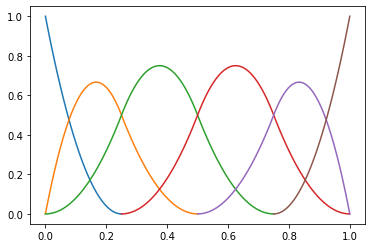

In [4]:
# make a vector of parametric points between 0 and 1
N = 100
ev = np.zeros((basis.size(),N))
xi = np.zeros((basis.size(),N))

for i in range(0,basis.size()):
    supp = basis.support(i)
    xi_tmp = xi[i,:] = np.linspace(supp[0,0],supp[0,1],N).reshape(-1,1).transpose()
    ev[i,:] = basis.function(i).eval(xi_tmp)


plt.plot(xi.transpose(),ev.transpose())
plt.show()

Now we add some coefficients

In [5]:
coefs = np.matrix([
                    [0.0],
                    [1.0],
                    [0.5],
                    [1.5],
                    [1.0],
                    [2.0]
                                ])

And now we define a spline, given control points $\Xi$ and B-spline basis functions basis functions $$\phi_i(x)$$, a B-spline ${S}$ is defined as:
$${S}(\xi) = \sum_i \mathbf{C}_i \phi_i(x)$$

In [6]:
spline = gs.nurbs.gsBSpline(basis,coefs)

The basis can be evaluated in G+Smo by evaluating all functions in their support region, i.e. the region where the function values are non-zero. When we then multiply each basis function with their corresponding coefficient, we get the contributions of the basis functions to the final spline.

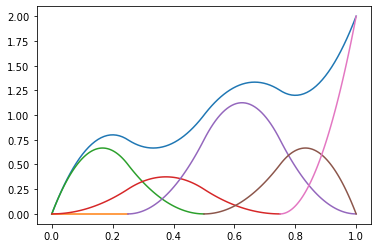

In [7]:
supp = basis.support()
xi = np.linspace(supp[0,0],supp[0,1],N).reshape(-1,1).transpose()
ev = spline.eval(xi)
plt.plot(xi.transpose(),ev.transpose())

ev = np.zeros((basis.size(),N))
xi = np.zeros((basis.size(),N))
for i in range(0,basis.size()):
    supp = basis.support(i)
    xi_tmp = xi[i,:] = np.linspace(supp[0,0],supp[0,1],N).reshape(-1,1).transpose()
    ev[i,:] = coefs[i,:].transpose() * basis.function(i).eval(xi_tmp)
    
plt.plot(xi.transpose(),ev.transpose())
plt.show()

In the same way, we can plot a 2D tensor basis using G+Smo. Here, we use the same knot vector in both directions.

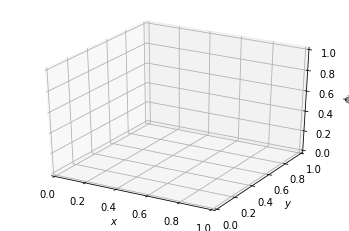

In [8]:
Xi_2 = Xi_1
basis2d = gs.nurbs.gsTensorBSplineBasis2(Xi_1,Xi_2)

nx = ny = 20
ev  = np.zeros((basis.size(),nx*ny))
xi  = np.zeros((basis.size(),nx*ny))
eta = np.zeros((basis.size(),nx*ny))

from IPython.display import display, clear_output
import time

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel("$x$")
ax.set_ylabel('$y$')
ax.set_zlabel('$\phi_i$')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_zlim(0,1)
for i in range(0,basis2d.size()):
# for i in [2,3,5]:
    supp = basis2d.support(i)
    x = np.linspace(supp[0,0], supp[0,1], nx)
    y = np.linspace(supp[1,0], supp[1,1], ny)
    xv, yv = np.meshgrid(x,y,indexing='xy')

    pts = np.stack((xv.flatten(),yv.flatten()))
    
    xi_tmp = xv.flatten()
    eta_tmp= yv.flatten()
    
    func = basis2d.function(i).eval(pts).reshape(nx,ny)
        
    # creating the plot
    surf = ax.plot_surface(xv,yv,func)
    display(fig)
    clear_output(wait = True)
    surf.remove()
    time.sleep(0.2)
    

## Read a spline from a file

In [9]:
mp = gs.core.gsMultiPatch()
gs.io.gsReadFile(os.path.join(gismo_path , "filedata/3dm/BB2_clean.3dm"),mp)

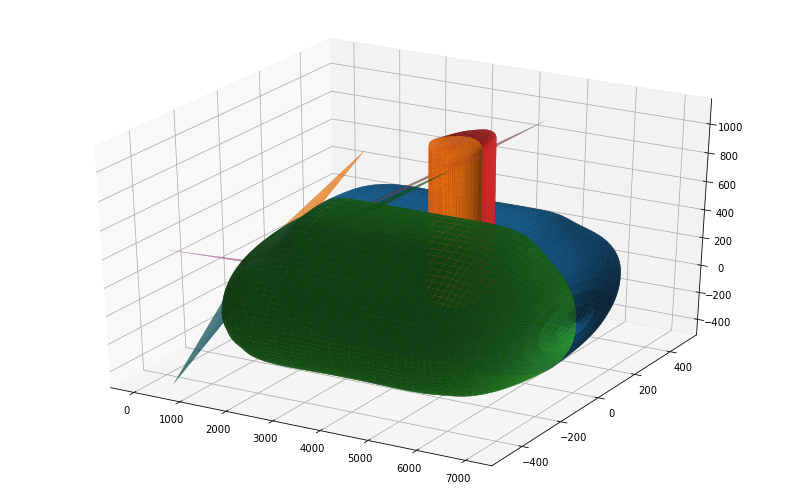

In [14]:
nx = ny = 100
x = np.linspace(0, 1, nx)

y = np.linspace(0, 1, ny)

xv, yv = np.meshgrid(x,y,indexing='xy')
pts = np.stack((xv.flatten(),yv.flatten()))

# creating figure
fig = plt.figure(figsize =(14, 9))
ax = fig.gca(projection='3d')
for p in range(0,mp.nPatches()):
    geom = mp.patch(p).eval(pts)
    x = geom[0,:].reshape(nx,ny)
    y = geom[1,:].reshape(nx,ny)
    z = geom[2,:].reshape(nx,ny)


    # creating the plot
    plot = ax.plot_surface(x,y,z)
  
# displaying the plot
plt.show()